In [68]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras

TensorFlow version: 2.9.1


In [69]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
from sklearn.preprocessing import Normalizer

## Loading a dataset

## Split into train data and test data as dataset
- データセットとして使用するデータを取得する。
- trainデータとtestデータに分割する。（例えば80%をtrainデータに、20%をtestデータに、など。）
- 書き方はデータセットとして使用するデータの type による。もし、numpy の形で持っているならhttps://www.tensorflow.org/tutorials/load_data/numpy?hl=ja が参考になります。

In [70]:


# x_path = '../../data/npy/x_random_l1_6.npy'
# x_path = '../../data/npy/x_random_6_diffseq_mean_l1.npy'
x_path = '../../data/npy/x_random_6_diffseq_mean_l1_2.npy'
x_data = np.load(x_path)

# y_path = '../../data/npy/y_random_l1_6.npy'
# y_path = '../../data/npy/y_random_6_diffseq_mean_l1.npy'
y_path = '../../data/npy/y_random_6_diffseq_mean_l1_2.npy'
y_data = np.load(y_path, allow_pickle=True)


print(len(y_data))

min_val = y_data.min()
max_val = y_data.max()

y_data = (y_data - min_val)/(max_val - min_val)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

print(len(x_train))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(len(x_train), 'train examples')
print(len(x_test), 'test examples')
print(len(y_train), 'train examples')


255
204
(204, 16)
(51, 16)
(204,)
(51,)
204 train examples
51 test examples
204 train examples


In [71]:
# print(transformer.get_params())
print(y_train)
print(y_test)
# 

[0.21843353 0.21645075 0.24181503 0.18906701 0.18692371 0.27210061
 0.19477561 0.28495437 0.24077811 0.17830447 0.24436011 0.19360244
 0.21230283 0.22344893 0.28654197 0.20802336 0.22017182 0.2336838
 0.25267565 0.1792144  0.23878361 0.26348515 0.22964759 0.19110706
 0.22828491 0.14489681 0.23959969 0.18190403 0.17128581 0.11193944
 1.         0.18945491 0.20001365 0.34881685 0.21165041 0.21594377
 0.2701163  0.20669201 0.1656011  0.28428667 0.47503182 0.22786593
 0.23775573 0.20570342 0.19881182 0.24081482 0.21031087 0.12276305
 0.18114101 0.24502441 0.19544443 0.27998828 0.24905598 0.2075224
 0.20417915 0.23728774 0.22034295 0.21571041 0.25181715 0.25274947
 0.19979964 0.16661746 0.23737463 0.19156397 0.23471255 0.23652653
 0.19959474 0.23600476 0.20340344 0.2550966  0.23315069 0.25784041
 0.22878839 0.21473604 0.21403284 0.15475699 0.23875498 0.23566889
 0.24087566 0.2311295  0.20137485 0.25717526 0.21759916 0.22527312
 0.27424834 0.23140383 0.22666052 0.21654965 0.21169185 0.219239

## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-l10n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [72]:
def build_model():
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [73]:
model = build_model()

In [74]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 128)               2176      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


In [75]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 16)
1/1 [==============================] - 0s 315ms/step


In [76]:
print(example_result)

[[ 0.12166441]
 [-0.11348082]
 [-0.13537347]
 [-0.01654991]
 [-0.04718005]
 [-0.02339426]
 [-0.13188235]
 [ 0.07723165]
 [ 0.1450372 ]
 [-0.22365487]]


In [77]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# EPOCHS = 400 # epoch 数も考慮しよう
EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [78]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,0.002108,0.034926,0.002108,0.003185,0.042439,0.003185,95
96,0.003509,0.042364,0.003509,0.003256,0.043083,0.003256,96
97,0.003969,0.044600,0.003969,0.003313,0.044031,0.003313,97
98,0.002904,0.040474,0.002904,0.003336,0.044769,0.003336,98
99,0.002790,0.037777,0.002790,0.003286,0.044507,0.003286,99


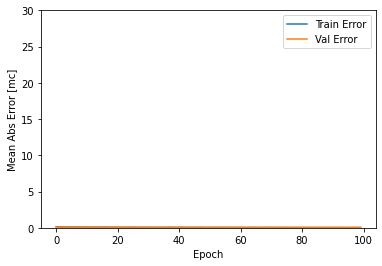

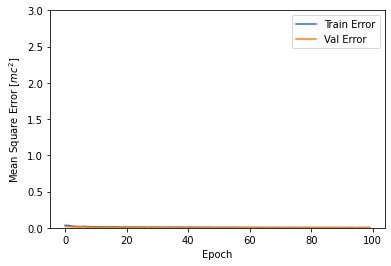

In [79]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

2/2 [==============================] - 0s 8ms/step


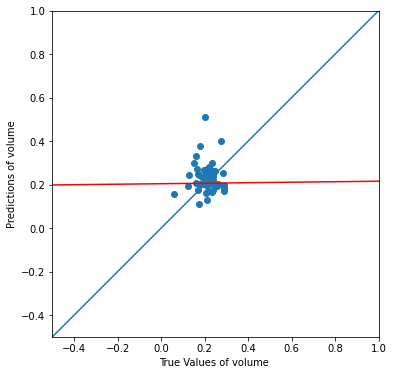

In [80]:
test_predictions = model.predict(x_test).flatten()
res = linregress(test_predictions, y_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values [mc]')
# plt.ylabel('Predictions [mc]')
plt.xlabel('True Values of volume ')
plt.ylabel('Predictions of volume')
plt.axis('equal')
plt.axis('square')
plt.xlim([-0.5,1])
plt.ylim([-0.5,1])
_ = plt.plot([-0.5, 1], [-0.5, 1])

plt.plot([-0.5, 1], res.intercept + res.slope*np.array([-1, 1]), 'r', label='fitted line')

# normalizer 学習前

7/7 [==============================] - 0s 3ms/step


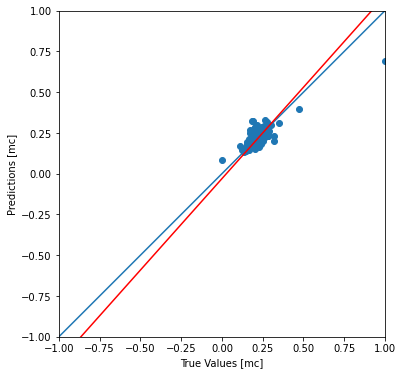

In [81]:
train_predictions = model.predict(x_train).flatten()
res = linregress(train_predictions, y_train)

plt.figure(figsize=(6,6))
plt.scatter(y_train, train_predictions)
plt.xlabel('True Values [mc]')
plt.ylabel('Predictions [mc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-1,1])
plt.ylim([-1,1])
_ = plt.plot([-1, 1], [-1, 1])

plt.plot([-1, 1], res.intercept + res.slope*np.array([-1, 1]), 'r', label='fitted line')

In [65]:
# トレーニングした model をどこかで使用したいなら以下のようにモデルを保存する
# model.save('../saved_model/random_l1_6_not_mean_model')

In [82]:
mse = tf.keras.losses.MeanSquaredError()

In [83]:
mse(y_test,test_predictions).numpy()

0.0068486477

In [84]:
test_predictions.rank

AttributeError: 'numpy.ndarray' object has no attribute 'rank'

In [19]:
test_predictions

array([0.54884195, 0.65218306, 0.5022442 , 0.51378673, 0.5368388 ,
       0.54469055, 0.5432773 , 0.51933324, 0.52177024, 0.5614668 ,
       0.5593387 , 0.45234552, 0.59461355, 0.50734365, 0.5493723 ,
       0.5208081 , 0.5635712 , 0.55117214, 0.5715706 , 0.5011642 ,
       0.5106604 , 0.61793756, 0.501809  , 0.6000018 , 0.5117352 ,
       0.42999288, 0.5113658 , 0.42552054, 0.62791693, 0.4606923 ,
       0.49495596, 0.58407116, 0.54335   , 0.46301913, 0.477862  ,
       0.48748514, 0.5497663 , 0.5268698 , 0.53361213, 0.7060776 ,
       0.62451065, 0.6592506 , 0.5525093 , 0.5224663 , 0.5511219 ,
       0.47766018, 0.49870783, 0.48989812, 0.4317764 , 0.5759    ,
       0.5687646 , 0.6395153 , 0.47532752, 0.39851892, 0.50865304,
       0.50578606, 0.42954975, 0.5235671 , 0.5581878 , 0.56464803,
       0.43385896, 0.4688043 , 0.5434368 , 0.47561532, 0.4762473 ,
       0.48626885, 0.48658663, 0.49085104, 0.5148406 , 0.47977358,
       0.65616345, 0.5029926 , 0.55106616, 0.50436175, 0.39320

In [20]:
type(y_test)

numpy.ndarray